In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import random
import math
from scipy.optimize import minimize as mini
from scipy.optimize import least_squares as ls
from scipy.optimize import leastsq

data = np.loadtxt('/home/lynge/MasterP/NOVEMBER/NOV-NGC3783-K')
error = np.loadtxt('/home/lynge/MasterP/NOVEMBER/NGC3783_NOISE_K.txt')

time1 = [1,2,3,4,5,6,7,8,9,10]
flux1 = [1,2,5,7,3,1,4,6,7,3]
sigma1 = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]


time1 = np.array(time1)
flux1 = np.array(flux1)
sigma1 = np.array(sigma1)

time = np.insert(time1,0,0)
sigma = np.insert(sigma1,0,np.mean(sigma1))
flux = np.insert(flux1,0,np.mean(flux1))

print time1
print sigma1
print flux1



In [2]:
data = np.loadtxt('NOVEMBER/NOV-NGC3783-K')
error = np.loadtxt('NOVEMBER/NGC3783_NOISE_K.txt')

#print data[:,0]
#print data[:,1]
#print error[:,0]
#print error[:,4]

time2 = data[:,0]
flux2 = data[:,1]
sigma2 = error[:,1]

time1 = []
flux1 = []
sigma1 = []

for i in range(len(time2)):
    if np.isnan(sigma2[i]):
        print 'yes'
    elif np.isnan(flux2[i]):
        print 'yes 2'
    else:
        time1.append(time2[i])
        flux1.append(flux2[i])
        sigma1.append(sigma2[i])

time1 = np.array(time1)
flux1 = np.array(flux1)
sigma1 = np.array(sigma1)

time = np.insert(time1,0,0)
sigma = np.insert(sigma1,0,np.mean(sigma1))
flux = np.insert(flux1,0,np.mean(flux1))

#print time1
#print sigma1
#print flux1

yes
yes
yes
yes 2
yes
yes 2
yes 2
yes 2
yes 2
yes


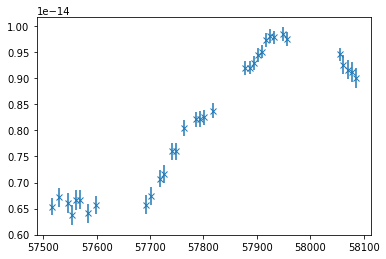

In [3]:
plt.figure()
plt.errorbar(time1,flux1,yerr=sigma1,fmt='x')
plt.show()

In [35]:
b = 8.*10**(-15)
tau = 200.
sigma_tot = 0.1 #2*10**(-16)

param = [b,tau,sigma_tot]

print param[1]

200.0


In [36]:
'''x denotes the observed fluxes, and t the observation times, 
sigma is the error variances and p is the probability function'''

def a_i(t2,t1,tau):
    tau = float(tau)
    return np.exp(-(t2-t1)/tau)

def omega_0(tau,sigma_tot):
    return 0.5*tau*sigma_tot**2

def omega_i(omega_0,a_i,omega_before,sigma_before):
    return omega_0*(1-a_i**2) + a_i**2*omega_before*(1 - omega_before/(omega_before + sigma_before**2))

def x_hat_i(a_i,x_hat_before,omega_before,sigma_before,x_star_before):
    return a_i*x_hat_before + a_i*omega_before/((omega_before + sigma_before**2))*(x_star_before - x_hat_before)

def x_star_i(x_i,b,tau):
    return x_i - b*tau


In [37]:
def dX(tau,sigma,dt,b,epsilon,X):
    return - 1/tau*X*dt + sigma*np.sqrt(dt)*epsilon + b*dt

In [38]:
def parameters(param):
    x_hat = [0]
    omega = [0.5*param[1]*param[2]**2]
    x_star = [-param[0]*param[1]]
    a = []
    for i in range(len(flux1)):
        a.append(a_i(time[i+1],time[i],param[1]))
        x_hat.append(x_hat_i(a[i],x_hat[i],omega[i],sigma[i],x_star[i]))
        omega.append(omega_i(omega_0(param[1],param[2]),a[i],omega[i],sigma[i]))
        x_star.append(x_star_i(flux[i+1],param[0],param[1]))
    return x_hat,omega,x_star,a


In [39]:
def prob(param):
    x_hat,omega,x_star,a = parameters(param)
    probability = 1
    for i in range(len(a)):
        #print omega[i+1],sigma[i+1],x_hat[i+1],x_star[i+1],a[i]
        part = (2*np.pi*(omega[i+1] + sigma[i+1]**2))**(-1/2.)\
        *np.exp(-(1/2.)*(x_hat[i+1] - x_star[i+1])/(omega[i+1] + sigma[i+1]**2))
        #print part,sigma1[i]
        probability *= part
    return -probability

In [40]:
print prob(param)

-199.799663762


In [41]:
res = mini(prob,param,method='Nelder-Mead',tol=1e-18)
print res.x

print np.mean(flux)

[ -6.40009060e-15   1.44617141e+03   1.74942211e-08]
8.17729033049e-15


/home/lynge/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in double_scalars
  
/home/lynge/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


In [42]:
b = res.x[0]
tau = res.x[1]
sigma_tot = res.x[2]

In [54]:
def dX(tau,sigma,dt,b,epsilon,X):
    return -(1/tau)*X*dt + sigma*np.sqrt(dt)*epsilon + b

In [55]:
flux_model = [flux1[0]]
print flux1

flux_test = flux1[0]
for i in range(len(flux1)-1):
    dt = (time1[i+1]-time1[i])
    epsilon = sigma[i]
    change = dX(tau,sigma_tot,dt,b,epsilon,flux1[i+1]) #flux1[i+1] - flux1[i]
    #print change,flux1[i+1]
    flux_model.append(flux_model[i] + change) # - flux_test)
    flux_test = flux_model[i+1]
print flux_model


[  6.53724662e-15   6.71527344e-15   6.60099894e-15   6.37713900e-15
   6.66855803e-15   6.67181077e-15   6.40972481e-15   6.56864377e-15
   6.57594350e-15   6.74248785e-15   7.06941435e-15   7.16508274e-15
   7.60092634e-15   7.60039417e-15   8.05099584e-15   8.21301406e-15
   8.22193811e-15   8.25153761e-15   8.38115563e-15   9.19988661e-15
   9.20615762e-15   9.29548448e-15   9.44518380e-15   9.50857590e-15
   9.73722913e-15   9.80940383e-15   9.78447827e-15   9.85013975e-15
   9.76320384e-15   9.45886211e-15   9.26290708e-15   9.16831540e-15
   9.11523113e-15   9.00052668e-15]
[6.5372466192675096e-15, 1.2872328454398848e-14, 1.919482315638248e-14, 2.5564046070394745e-14, 3.1927247229690837e-14, 3.8295043824900357e-14, 4.4633083596958798e-14, 5.0965042824942708e-14, 5.693315517646755e-14, 6.3295947366829734e-14, 6.9608047399377391e-14, 7.5973456376816463e-14, 8.2294708547044487e-14, 8.8652754929965266e-14, 9.4969338882690941e-14, 1.0124448834970097e-13, 1.0759909644530035e-13, 1.139

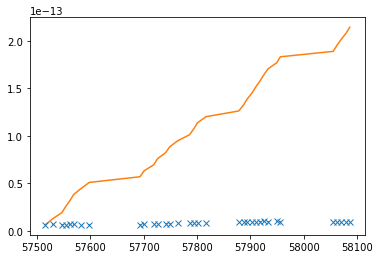

In [56]:
plt.figure()
plt.errorbar(time1,flux1,yerr=sigma1,fmt='x')
plt.plot(time1,flux_model)
plt.show()